In [18]:
import numpy as np
import ROOT
import matplotlib.pyplot as plt
from matplotlib import cycler, patches
import xml.dom.minidom as minidom

import sys

sys.path.insert(1, '../..')
from pmt_he_study.format_plot import *
from functions.other_functions import *
from src.PMT_Classes import *
from array import array
from scipy.optimize import curve_fit

In [19]:
IPython_default = plt.rcParams.copy()
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

figsize = (4.5, 3)

plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams["font.family"] = "serif"

marker_size = 3
line_width = 0.5

colors = cycler('color', ['#EE6666', '#3388BB', '#9988DD', '#EECC55', '#88BB44', '#FFBBBB', '#653700', '#F97306'])
plt.rc('axes', facecolor='white', edgecolor='black',
       axisbelow=True, grid=True, prop_cycle=colors)



Amplitude scale = 1.9571128798282273
Unit Charge = 0.12286878056263545
TFile**		/Users/williamquinn/Desktop/SNEMO/pmt_short_templates.root	
 TFile*		/Users/williamquinn/Desktop/SNEMO/pmt_short_templates.root	
  KEY: TH1D	Template_Ch0;1	Template_Ch0
  KEY: TH1D	Template_Ch1;1	Template_Ch1


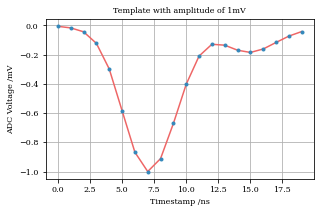

In [69]:
template_file = ROOT.TFile("/Users/williamquinn/Desktop/SNEMO/pmt_short_templates.root")
template_file.ls()

h_template = template_file.Get("Template_Ch0")
x = []
y = []

for i in range(1, h_template.GetNbinsX()+1):
    x.append(i-1)
    y.append(h_template.GetBinContent(i))
    #print(i, h_template.GetBinContent(i))
y = np.array(y)
x = np.array(x)

plt.figure(figsize=figsize, facecolor='white')
plt.plot(x, y/(-1*np.amin(y)))
plt.plot(x, y/(-1*np.amin(y)), ".")
plt.title("Template with amplitude of 1mV")

plt.xlabel("Timestamp /ns")
plt.ylabel("ADC Voltage /mV")
#y = y/(-1*np.amin(y))

normalised_y = y/np.dot(y,y)
unit_y = y/(-1*np.amin(y))

amp_scale = np.dot(normalised_y, unit_y)/np.sqrt(np.dot(normalised_y,normalised_y))

print("Amplitude scale =", amp_scale)
print("Unit Charge =", -1*np.sum(unit_y)/50)
plt.tight_layout()
plt.savefig("/Users/williamquinn/Desktop/PMT_Project/pmt_short_template_ch0.pdf")

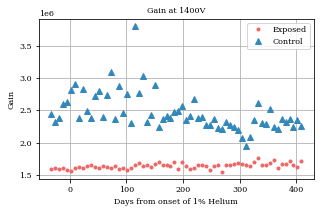

In [89]:
file = file = open("/Users/williamquinn/Desktop/test.csv", "r")
fl = file.readlines()
w = []
gain_ch0 = []
gain_ch1 = []
av_charge_ch0 = []
av_charge_ch1 = []
for index, line in enumerate(fl):
    if index == 0:
        continue
    line_list = line.split(",")
    w.append(int(line_list[0]))
    gain_ch0.append(float(line_list[5])/float(line_list[1]) * float(line_list[3]))
    gain_ch1.append(float(line_list[6])/float(line_list[2]) * float(line_list[4]))
    av_charge_ch0.append(float(line_list[7]))
    av_charge_ch1.append(float(line_list[8]))
    
w = np.array(w)
gain_ch0 = np.array(gain_ch0)
gain_ch1 = np.array(gain_ch1)
av_charge_ch0 = np.array(av_charge_ch0)
av_charge_ch1 = np.array(av_charge_ch1)
gains = [gain_ch0, gain_ch1]

plt.figure(figsize=figsize, facecolor='white')

plt.plot(w*7 + 3, gain_ch0, ".", label='Exposed')
plt.plot(w*7 + 3, gain_ch1, "^", label='Control')
plt.legend(loc='best')

plt.ylabel("Gain")
plt.xlabel("Days from onset of 1% Helium")
plt.title("Gain at 1400V")
plt.tight_layout()
plt.savefig("/Users/williamquinn/Desktop/PMT_Project/gain_1400V.pdf")

In [25]:
topology = [2, 1]
pmt_array = PMT_Array(topology, "summary")
pmt_array.set_pmt_id("GAO612", 1)
pmt_array.set_pmt_id("GAO607", 0)
    
filenames_txt = "/Users/williamquinn/Desktop/data/set_5/filenames.txt"
try:
    print(">>> Reading data from file: {}".format(filenames_txt))
    date_file = open(filenames_txt, 'r')
except FileNotFoundError as fnf_error:
    print(fnf_error)
    raise Exception("Error opening data file {}".format(filenames_txt))

filenames = np.loadtxt(filenames_txt, delimiter=',', dtype={
        'names': ['filename'],
        'formats': ['S100']}, unpack=True)

dates = [[], []]
ap_charges = [[], []]
ap_pes =[[], []]

for i_file in range(filenames.size):
    filename = filenames[i_file][0].decode("utf-8")
    date = filename.split("_")[0]
    voltage = int(filename.split("_")[1].split("A")[1])
    week = process_date([int(date)])[0] // 7
    print("> File:", filename, "week:", week)
    
    file = ROOT.TFile("/Users/williamquinn/Desktop/data/set_5/" + filename, "READ")
    file.cd()
    tree = file.T
    
    temp_charge = []
    temp_pe = []
    
    for event in tree:
        om = event.OM_ID
        if om == 1:
            continue
        amps = list(event.apulse_amplitudes)
        shapes = list(event.apulse_shapes)
        ts = list(event.apulse_times)
        
        try:
            gain = gains[om][week + 5]
        except:
            print(week, date)
        
        for i_ap, ap in enumerate(amps):
            shp = shapes[i_ap]
            if shp < 0.95:
                continue
            charge = -1*np.sum(unit_y)*ap/amp_scale /50
            pe = charge*1e-12 /gain /1.602e-19 
            temp_charge.append(charge)
            temp_pe.append(pe)
    dates[om].append(process_date([int(date)])[0])      
    ap_charges[om].append(np.average(temp_charge))
    ap_pes[om].append(np.average(temp_pe))


#plot_aan(dates, nums, nums_err, "")
#plot_aan(dates, he_nums, he_nums_err, "he")
print(">>> Finished")

>>> Reading data from file: /Users/williamquinn/Desktop/data/set_5/filenames.txt
> File: 191008_A1400_B1400_t1519.root week: -5
> File: 191009_A1400_B1400_t1540.root week: -4
> File: 191010_A1400_B1400_t1448.root week: -4
> File: 191011_A1400_B1400_t1319.root week: -4
> File: 191012_A1400_B1400_t1958.root week: -4
> File: 191013_A1400_B1400_t1940.root week: -4
> File: 191014_A1400_B1400_t1752.root week: -4
> File: 191015_A1400_B1400_t1258.root week: -4
> File: 191016_A1400_B1400_t1423.root week: -3
> File: 191017_A1400_B1400_t1232.root week: -3
> File: 191018_A1400_B1400_t1356.root week: -3
> File: 191019_A1400_B1400_t1816.root week: -3
> File: 191020_A1400_B1400_t1637.root week: -3
> File: 191021_A1400_B1400_t1425.root week: -3
> File: 191023_A1400_B1400_t1601.root week: -2
> File: 191024_A1400_B1400_t1421.root week: -2
> File: 191025_A1400_B1400_t1701.root week: -2
> File: 191027_A1400_B1400_t1545.root week: -2
> File: 191028_A1400_B1400_t1408.root week: -2
> File: 191029_A1400_B1400

> File: 200407_A1400_B1400_t1020.root week: 21
> File: 200408_A1400_B1400_t1717.root week: 22
> File: 200409_A1400_B1400_t1139.root week: 22
> File: 200410_A1400_B1400_t1225.root week: 22
> File: 200411_A1400_B1400_t1048.root week: 22
> File: 200412_A1400_B1400_t1356.root week: 22
> File: 200413_A1400_B1400_t1115.root week: 22
> File: 200414_A1400_B1400_t1000.root week: 22
> File: 200415_A1400_B1400_t1130.root week: 23
> File: 200416_A1400_B1400_t1030.root week: 23
> File: 200417_A1400_B1400_t1151.root week: 23
> File: 200418_A1400_B1400_t1040.root week: 23
> File: 200419_A1400_B1400_t1104.root week: 23
> File: 200420_A1400_B1400_t0956.root week: 23
> File: 200421_A1400_B1400_t1020.root week: 23
> File: 200422_A1400_B1400_t0958.root week: 24
> File: 200423_A1400_B1400_t1052.root week: 24
> File: 200424_A1400_B1400_t1607.root week: 24
> File: 200425_A1400_B1400_t1203.root week: 24
> File: 200426_A1400_B1400_t1055.root week: 24
> File: 200427_A1400_B1400_t1007.root week: 24
> File: 20042

> File: 201026_A1400_B1400_t1010.root week: 50
> File: 201027_A1400_B1400_t1409.root week: 50
> File: 201028_A1400_B1400_t2352.root week: 51
> File: 201029_A1400_B1400_t1036.root week: 51
> File: 201030_A1400_B1400_t1620.root week: 51
> File: 201101_A1400_B1400_t2223.root week: 51
> File: 201102_A1400_B1400_t1008.root week: 51
> File: 201104_A1400_B1400_t2159.root week: 52
> File: 201106_A1400_B1400_t1200.root week: 52
> File: 201108_A1400_B1400_t2034.root week: 52
> File: 201109_A1400_B1400_t1653.root week: 52
> File: 201110_A1400_B1400_t2149.root week: 52
> File: 201111_A1400_B1400_t2347.root week: 53
> File: 201112_A1400_B1400_t1416.root week: 53
> File: 201113_A1400_B1400_t1108.root week: 53
> File: 201114_A1400_B1400_t1142.root week: 53
> File: 201115_A1400_B1400_t2240.root week: 53
> File: 201116_A1400_B1400_t1116.root week: 53
> File: 201117_A1400_B1400_t1127.root week: 53
> File: 201118_A1400_B1400_t1143.root week: 54
> File: 201119_A1400_B1400_t1756.root week: 54
> File: 20112

In [85]:
y = [[], []]
x = [[], []]
for i in range(len(ap_charges)):
    for j in range(len(ap_charges[i])):
        if ap_charges[i][j] > 4:
            pass
        else:
            y[i].append(ap_charges[i][j])
            x[i].append(dates[i][j])

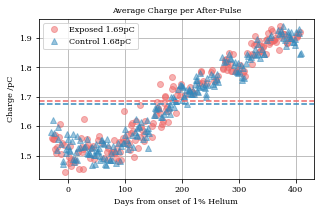

In [86]:
plt.figure(figsize=figsize, facecolor='white')
plt.plot(x[0], y[0], "o", label='Exposed {:.2f}pC'.format(np.average(y[0])), alpha=0.5)
plt.plot(x[1], y[1], "^", label='Control {:.2f}pC'.format(np.average(y[1])), alpha=0.5)
plt.axhline(np.average(y[0]), ls='--', color='C0')
plt.axhline(np.average(y[1]), ls='--', color='C1')
plt.ylabel("Charge /pC")
plt.xlabel("Days from onset of 1% Helium")
plt.title("Average Charge per After-Pulse")
plt.legend(loc='best')
plt.tight_layout()
plt.savefig("/Users/williamquinn/Desktop/PMT_Project/av_ap_charge_vs_time.pdf")

In [87]:
y = [[], []]
x = [[], []]
for i in range(len(ap_pes)):
    for j in range(len(ap_pes[i])):
        if ap_pes[i][j] > 10:
            pass
        else:
            y[i].append(ap_pes[i][j])
            x[i].append(dates[i][j])

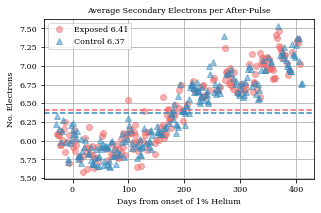

In [88]:
plt.figure(figsize=figsize, facecolor='white')
plt.plot(x[0], y[0], "o", label='Exposed {:.2f}'.format(np.average(y[0])), alpha=0.5)
plt.axhline(np.average(y[0]), color="C0", ls='--')
plt.plot(x[1], y[1], "^", label='Control {:.2f}'.format(np.average(y[1])), alpha=0.5)
plt.axhline(np.average(y[1]), color="C1", ls='--')
plt.ylabel("No. Electrons")
plt.xlabel("Days from onset of 1% Helium")
plt.title("Average Secondary Electrons per After-Pulse")
plt.legend(loc='best')
plt.tight_layout()
plt.savefig("/Users/williamquinn/Desktop/PMT_Project/av_ap_pe_vs_time.pdf")